In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import utils as u

notes_dict = {
"Sa": 0,
"Ri": 100,
"Ga": 300,
"Ma": 500,
"Pa": 700,
"Dha": 800,
"Ni": 1000,
"Sa": 1200,
"Ri": 1300,
"Ga": 1500,
}
sr = 16000

In [14]:
# Load the pitch contour
pitchfile = "thodi/Thappi Bratikipova/Thappi Bratikipova.multitrack-violin-main.pitch"
times, f0, conf = np.loadtxt(pitchfile).T

# Track info
raga, piece, instrument, section = u.process_filename(pitchfile)
print("Raga:", raga)
print("Piece:", piece)
print("Instrument:", instrument)
print("Section:", section)

# Load the tonics
vitonic_path = raga + "/" + piece + "/" + piece + ".multitrack-violin-main.tonic"
votonic_path = raga + "/" + piece + "/" + piece + ".ctonic.txt"
tonic_violin = np.loadtxt(vitonic_path)
tonic_vocal = np.loadtxt(votonic_path)
print("Violin tonic:", tonic_violin, "Hz, Vocal tonic:", tonic_vocal, "Hz")

# Set the tonic based on the instrument
if instrument == "vocal":
    tonic = tonic_vocal
    print("Using vocal tonic")
else:
    tonic = tonic_violin
    print("Using violin tonic")

Raga: thodi
Piece: Thappi Bratikipova
Instrument: violin
Section: main
Violin tonic: 147.07455444335938 Hz, Vocal tonic: 146.832384 Hz
Using violin tonic


In [15]:
# Length of audio in seconds
length_s = times[-1]
print("Length of audio in seconds: {:.2f} s".format(length_s))

# Pitch contour frame rate
frameRate = int(len(f0)/length_s)  
print("Pitch contour frame rate:", frameRate)

# Get voiced segments
voiced_segments = u.voiced_segments(f0)
print("Number of voiced segments:", len(voiced_segments))

Length of audio in seconds: 1129.00 s
Pitch contour frame rate: 133
Number of voiced segments: 299


Selected threshold: 0.023584159519523383


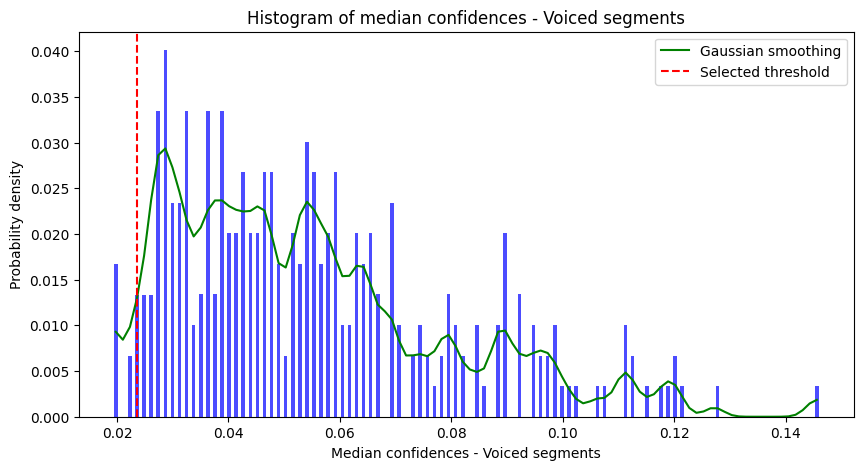

In [20]:
# Removing segments with low confidence estimation
median_conf = u.median_confidences(conf, voiced_segments)
plt.figure(figsize=(10, 5))
hist, bin_edges = np.histogram(median_conf, bins = 100, density = True)
hist = hist/np.sum(hist)
peaks = u.find_minimas(hist, height = 0.015)
gaussian_fit = u.gaussian_filter(hist, 10, sigma = 1.5)
threshold = bin_edges[3]
print("Selected threshold:", threshold)
plt.bar(bin_edges[:-1], hist, width = 0.5*(bin_edges[1] - bin_edges[0]), color = 'b', alpha = 0.7)
plt.plot(bin_edges[:-1], gaussian_fit, color = 'g', label = "Gaussian smoothing")
plt.axvline(x = threshold, color = 'r', linestyle = '--', label = "Selected threshold")
plt.xlabel("Median confidences - Voiced segments")
plt.ylabel("Probability density")
plt.title("Histogram of median confidences - Voiced segments")
plt.legend()
plt.show()

In [21]:
# Keeping and discarding segments based on threshold
f0_filt = f0.copy()
f0_disc = f0.copy()
print("Selected threshold: {:.3f}".format(threshold))

# # Manual threshold (if necessary)
# threshold = 0.02

for i in range(len(voiced_segments)):
    if median_conf[i] < threshold:
        start = voiced_segments[i][0]
        end = voiced_segments[i][1] + 1
        f0_filt[start:end] = 0
    if median_conf[i] > threshold:
        start = voiced_segments[i][0]
        end = voiced_segments[i][1] + 1
        f0_disc[start:end] = 0

# Print the number of voices segments in f0_filt, f0_disc and f0
voiced_segments_filt = u.voiced_segments(f0_filt)
voiced_segments_disc = u.voiced_segments(f0_disc)
print("Number of voiced segments in f0_filt:", len(voiced_segments_filt))
print("Number of voiced segments in f0_disc:", len(voiced_segments_disc))
print("Number of voiced segments in f0:", len(voiced_segments))

Selected threshold: 0.024
Number of voiced segments in f0_filt: 292
Number of voiced segments in f0_disc: 7
Number of voiced segments in f0: 299


#### Octave estimation errors

Number of octave jumps in f0_filt: 17


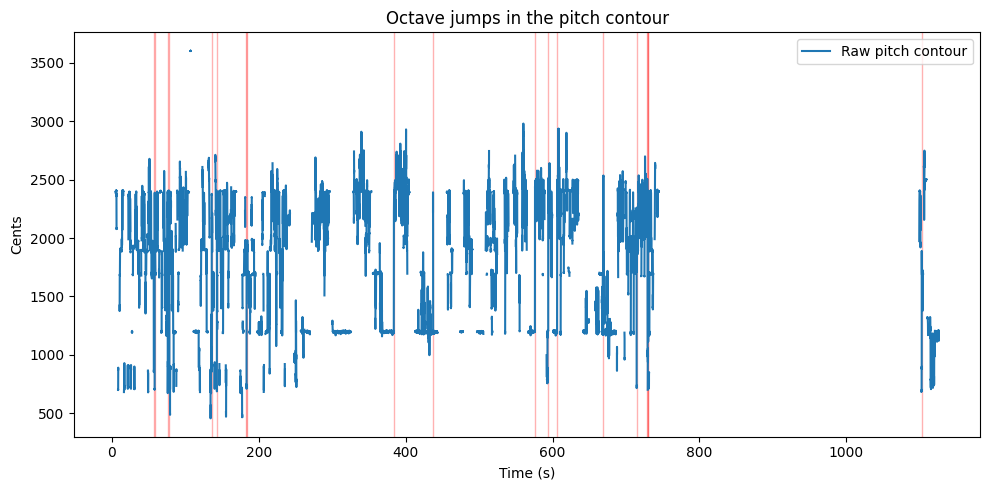

In [22]:
octave_jumps = u.octave_jumps(u.hz_to_cents(f0_filt, tonic), voiced_segments_filt, jump_threshold = 1000)
merged_jumps = u.merge_intervals(octave_jumps)
print("Number of octave jumps in f0_filt:", len(merged_jumps))

plt.figure(figsize=(10, 5))
plt.plot(times, u.hz_to_cents(f0_filt, tonic), label = "Raw pitch contour")
plt.xlabel("Time (s)")
plt.ylabel("Cents")
for jump in merged_jumps:
    plt.axvspan(times[jump[0]], times[jump[1]], color = 'r', alpha = 0.3)
plt.title("Octave jumps in the pitch contour")
plt.legend()
plt.tight_layout()
plt.show()

Number of octave jumps:  17
Number of octave jumps: 13
Number of octave jumps: 11
Number of octave jumps: 10
Number of octave jumps: 9
Number of octave jumps: 9
Number of octave jumps: 9
Number of octave jumps: 9
Number of octave jumps: 9
Number of octave jumps: 9


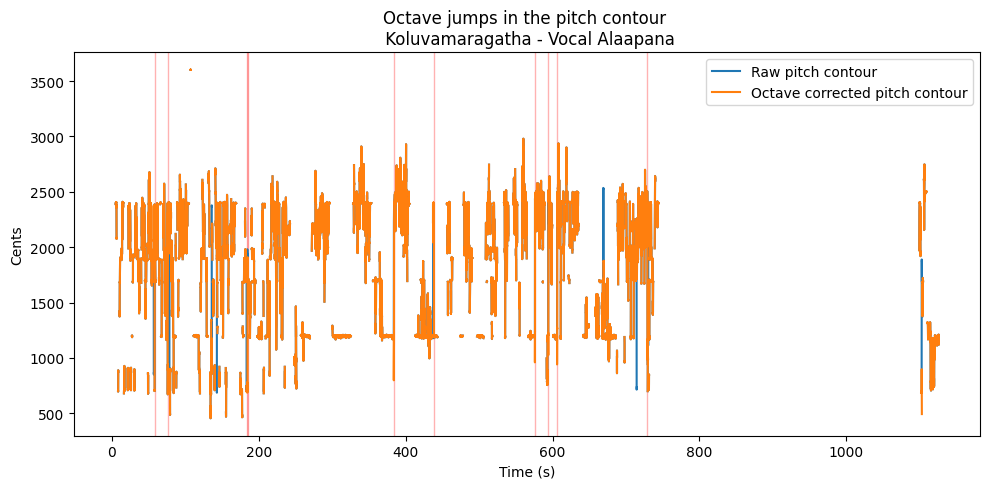

In [23]:
# Correct octave errors
f0_corr = u.correct_octave_jump(u.hz_to_cents(f0_filt, tonic))
f0_corr = u.cents_to_hz(f0_corr, tonic)

# Recalculate the octave jumps
octave_jumps = u.octave_jumps(u.hz_to_cents(f0_corr, tonic), voiced_segments_filt, jump_threshold = 1000)
merged_jumps = u.merge_intervals(octave_jumps)

plt.figure(figsize=(10, 5))
plt.plot(times, u.hz_to_cents(f0_filt, tonic), label = "Raw pitch contour")
plt.plot(times, u.hz_to_cents(f0_corr, tonic), label = "Octave corrected pitch contour")
plt.xlabel("Time (s)")
plt.ylabel("Cents")
for jump in merged_jumps:
    plt.axvspan(times[jump[0]], times[jump[1]], color = 'r', alpha = 0.3)
plt.title("Octave jumps in the pitch contour \n Koluvamaragatha - Vocal Alaapana")
plt.legend()
plt.tight_layout()
plt.show()


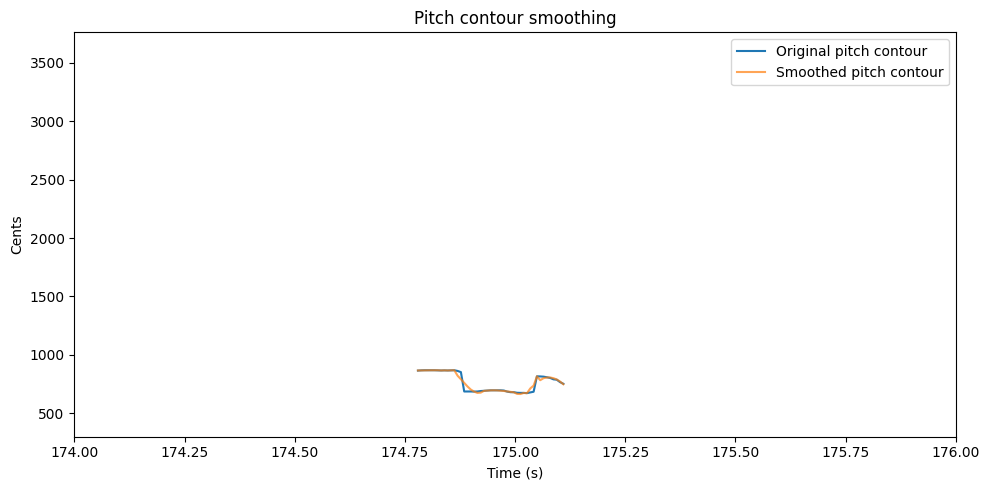

In [24]:
# Pitch contour smoothing and interpolation
window_ms = 100
window_samples = u.ms_to_samples(window_ms, 133)
# Ensure window_samples is odd
if window_samples % 2 == 0:
    window_samples += 1
# Smooth contour
f0_smoothed = u.savitsky_golay_filter(f0_corr, window_samples, 2, peak = True)

plt.figure(figsize=(10, 5))
plt.plot(times, u.hz_to_cents(f0_corr, tonic), label = "Original pitch contour")
plt.plot(times, u.hz_to_cents(f0_smoothed, tonic), label = "Smoothed pitch contour", alpha = 0.7)
plt.xlabel("Time (s)")
plt.ylabel("Cents")
plt.xlim(174, 176)
# plt.yticks(list(notes_dict.values()), list(notes_dict.keys()))
plt.title("Pitch contour smoothing")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# Save processed pitch contour
processedfile = pitchfile.replace(".pitch", "-processed.pitch")
np.savetxt(processedfile, np.array([times, f0_smoothed]).T)